# Prof. Keller's Method Fit

- Produce replicas by varying F within errF from data (set 0)
- Perform fits to all replicas and obtain a distribution of CFFs
- Determine the mean and sigma of CFFs
- Using the mean, sigma of CFFs and varying kinematics, produce F values using the function(Note: the range of kinematics shouldn't exceed the values of next data set)
- Build a new ANN model with the data generated in (4) -- Inputs: Kinematics & F / Outputs: CFFs
- Produce samples of F varying within errF from the initial data and combine with initial kinematics
- Feed the samples (from 6) to the ANN model built in (5) -- Output: a distribution of CFFs


In [3]:
%load_ext autoreload
%autoreload 2

In [15]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

from BHDVCStf import BHDVCS #modified bhdvcs file
import utilities as uts

## Setup

In [5]:
numSets = 15
numReplicas = 500

df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = uts.DvcsData(df)

In [20]:
localFits = np.fromfile('replicas500.txt')
localFits = replicas.reshape(numSets, numReplicas, 3)

## Generate Pseudo-Data

In [12]:
class step3sim(object):
    def __init__(self, X, replicas, whichSet, numSamples=10000):
        # sample range of 10,000, with replicas repeated and appended to fill
        
        self.X = X
        self.cffs = replicas[whichSet, :, :]
        self.whichSet = whichSet
        if int(numSamples**.25)**4 != numSamples:
            numSamples = int(numSamples**.25)**4
            print('numSamples must be perfect power of 4, using ' + str(numSamples) + ' instead!')
        
        self.numSamples = numSamples
        
        self.kins = X.loc[whichSet*36, ['k', 'QQ', 'x_b', 't']]
        self.dvcs = X.loc[whichSet*36, 'dvcs']
            
    
    def _getKinRange(self, whichKin):
        
        krange = np.unique(self.X[whichKin].sort_values())
        idx = np.where(krange == self.kins[whichKin])[0][0]
        num = int(self.numSamples**.25)
        
        #return krange, idx, num
        if idx == 0:
            to_ret = np.linspace(self.kins[whichKin]*2 - krange[idx + 1], krange[idx + 1], num=num)
        elif idx == (len(krange) - 1):
            to_ret = np.linspace(krange[idx - 1], 2*self.kins[whichKin] - krange[idx - 1], num=num)
        else:
            to_ret = np.linspace(krange[idx - 1], krange[idx + 1], num=num)
        return to_ret

    
    def addFs(self, sd):
        bhdvcs = BHDVCS()
        sd['F'] = bhdvcs.TotalUUXS(np.array(sd[['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]),
                                  np.array(sd['ReH']), np.array(sd['ReE']), np.array(sd['ReHtilde']))
        return sd    

    
    def getSimData(self):
        kins = [self._getKinRange(kin) for kin in ['k', 'QQ', 'x_b', 't']]
        kins = np.array(np.meshgrid(*kins)).T.reshape(-1,4)
        to_ret = {key: [] for key in self.X.columns}
        to_ret['k'] = kins[:, 0]
        to_ret['QQ'] = kins[:, 1]
        to_ret['x_b'] = kins[:, 2]
        to_ret['t'] = kins[:, 3]
        
        to_ret['F1'] = uts.f1_f2.ffF1(to_ret['t'])
        to_ret['F2'] = uts.f1_f2.ffF1(to_ret['t'])
        
        #cffs = np.repeat(self.cffs, 100, axis=0) #needs to be changed to accomodate numSamples
        #np.random.shuffle(cffs)
                
        rees = self.cffs[:, 0]
        rehs = self.cffs[:, 1]
        rehtildes = self.cffs[:, 2]
        
        #can also be uniform
        to_ret['ReH'] = np.random.normal(rees.mean(), rees.std(), size=self.numSamples)
        to_ret['ReE'] = np.random.normal(rehs.mean(), rehtildes.std(), size=self.numSamples)
        to_ret['ReHtilde'] = np.random.normal(rehtildes.mean(), rehtildes.std(), size=self.numSamples)
        
        to_ret['dvcs'] = np.repeat(self.dvcs, self.numSamples)
        
        phis = np.repeat(np.linspace(0, 350, 36), self.numSamples//36 + 1)
        to_ret['phi_x'] = phis[:self.numSamples]
        
        sd = pd.DataFrame(to_ret)
        sd = self.addFs(sd)
        return sd
    

In [40]:
def fit_pred_kinSet(whichSet, data, localFits, numReplicas):
    
    s3 = step3sim(data.X, localFits, whichSet)
    locData = s3.getSimData()
    
    locData = locData.dropna()
    
    rescaler = MinMaxScaler()
    rescaler = rescaler.fit(locData[['k', 'QQ', 'x_b', 't', 'F']])
    X = rescaler.transform(locData[['k', 'QQ', 'x_b', 't', 'F']])
    y = locData[['ReH', 'ReE', 'ReHtilde']]
    
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=(5,), activation="elu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(20, activation="elu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(3)
    ])
    
    model.compile(
    optimizer = tf.keras.optimizers.Nadam(.01),
    loss = tf.keras.losses.MeanSquaredError()
    )
    
    model.fit(X, y, epochs=100, verbose=0)
        

    #to_pred = np.tile(np.array(data.Kinematics.loc[whichSet*36 + 18, :]), (100, 1)) 

    to_pred = pd.concat([data.Kinematics.loc[[whichSet*36 + 18], :] for _ in range(numReplicas)]) #phi=180
    to_pred['F'] = [data.getSet(whichSet).sampleY()[18] for _ in range(numReplicas)] #phi=180
    
    to_pred = rescaler.transform(to_pred)
    
    #yhat = np.stack([model(to_pred, training=True) for sample in range(100)]).reshape()
    
    return model.predict(to_pred)

In [45]:
def produceResults(data, localFits, numSets, numReplicas):
    '''
    data: a tensorflow neural network model
    X: [standardized kins, xnocff]
    orig_weights: the original weights from when the model was created (used to reset model after it has been trained)
    numSets: the number of kinematic sets
    numReplicas: the number of replicas
    
    returns: np array of cff predictions of shape (numSets, numReplicas, numCFFs)
    '''
    by_set = []
    for i in tqdm(range(numSets)):
        by_set.append(fit_pred_kinSet(i, data, localFits, numReplicas).tolist())

    return np.array(by_set)

In [46]:
results = produceResults(data, localFits, numSets, numReplicas)

# ReH

In [49]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 0)

Mean percent error:  12.863396196930605
RMSE:  1.203155988751595
RMSE w yhat=mean:  2.5254628436780107
R-squared:  0.7730334230889361


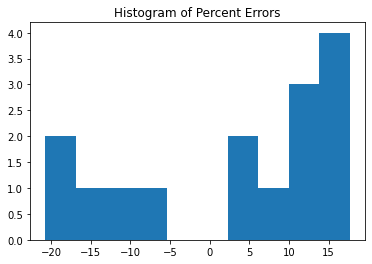

In [50]:
uts.evaluate(y_yhat)

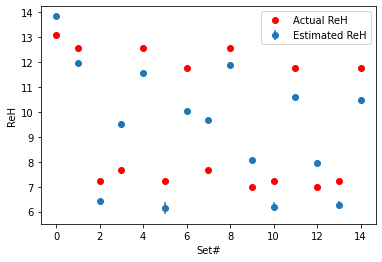

In [51]:
uts.plotError(y_yhat, err, "ReH")

# ReE

Mean percent error:  10.256630981052714
RMSE:  5.34813696422541
RMSE w yhat=mean:  2.525480507907797
R-squared:  -3.4845306848792843


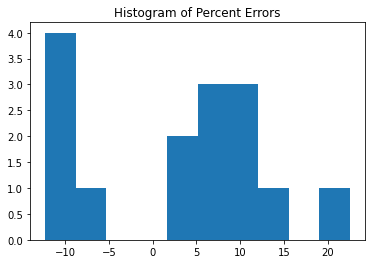

In [52]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 1)
uts.evaluate(y_yhat)

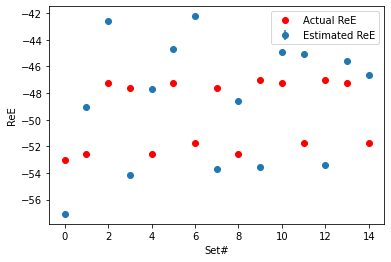

In [53]:
uts.plotError(y_yhat, err, "ReE")

# ReHtilde

Mean percent error:  9.117071658150644
RMSE:  0.48185272710842264
RMSE w yhat=mean:  1.4030345621243816
R-squared:  0.8820516408463649


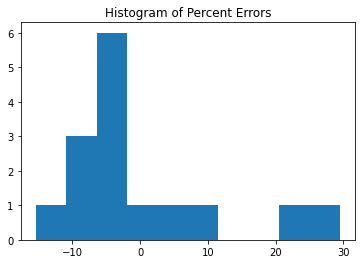

In [54]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 2)
uts.evaluate(y_yhat)

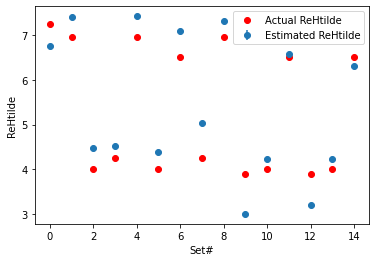

In [55]:
uts.plotError(y_yhat, err, "ReHtilde")

# Propagated Fs at 180

Use the compton form factors as inputs to TotalUUXS to estimate the distribution of F, then compare it with the baseline.

Mean percent error:  9.894717657006995
RMSE:  0.0029334155399000175
RMSE w yhat=mean:  0.015855649879790133
R-squared:  0.9657721923948477


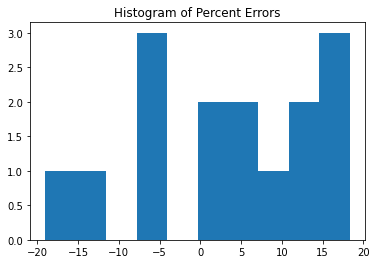

In [56]:
y_yhat, err = uts.y_yhat_errFs(results, data)
uts.evaluate(y_yhat)

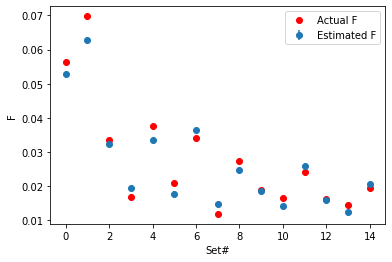

In [57]:
uts.plotError(y_yhat, err, "F")